In [1]:
# cell 1: import stuff
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import glob
%matplotlib inline


In [2]:
# cell 2: camera calibraiton
images = glob.glob('camera_cal/calibration*.jpg')
nx = 9 
ny = 6

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     mpimg.imread() #if this
#     cv2.COLOR_RGB2GRAY #then that
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

In [20]:
# cell 3: catch lane
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def pipeline(img, s_thresh=(70, 255), sx_thresh=(35, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined = np.zeros_like(sxbinary)
    grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=5, thresh_max=100)

#    combined[((sxbinary == 1) | (s_binary == 1))] = 1
    mag_binary = mag_thresh(img, sobel_kernel_1, mag_thresh=(30, 100))
    combined[((mag_binary == 1) | (s_binary == 1))] = 1
    
    return combined


In [21]:
# cell 4: warp image (bird-eye view)
src=np.float32([[275,668],[1024,668],[577,462],[703,462]])
dst = np.float32([[200,700],[1280-200,700],[200,20],[1280-200,20]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

# input binary, output warped binary
def warp(img):
    img_size=(img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size,flags=cv2.INTER_LINEAR)
    return warped


In [22]:
sobel_kernel_1= 3
sobel_kernel_2= 15

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# find curvature
def FindCurv(leftx,lefty,rightx,righty):
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in my image, not 700!!!
    y_eval = 720
    left_fit_cr  = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curverad = (left_curverad + right_curverad)/2

 
    camera_position = image.shape[0]/2*xm_per_pix
    left = leftx*xm_per_pix
    right = rightx*xm_per_pix
    lane_center = (right[700] + left[700])/2
    center_offset_pixels = (camera_position - lane_center)/2
   
    ccc = str(curverad)
    ddd = str(center_offset_pixels)
    out1 = ccc+ 'm'
    out2 = ddd+'m (negative is left; positive is right)' 
    return out1, out2


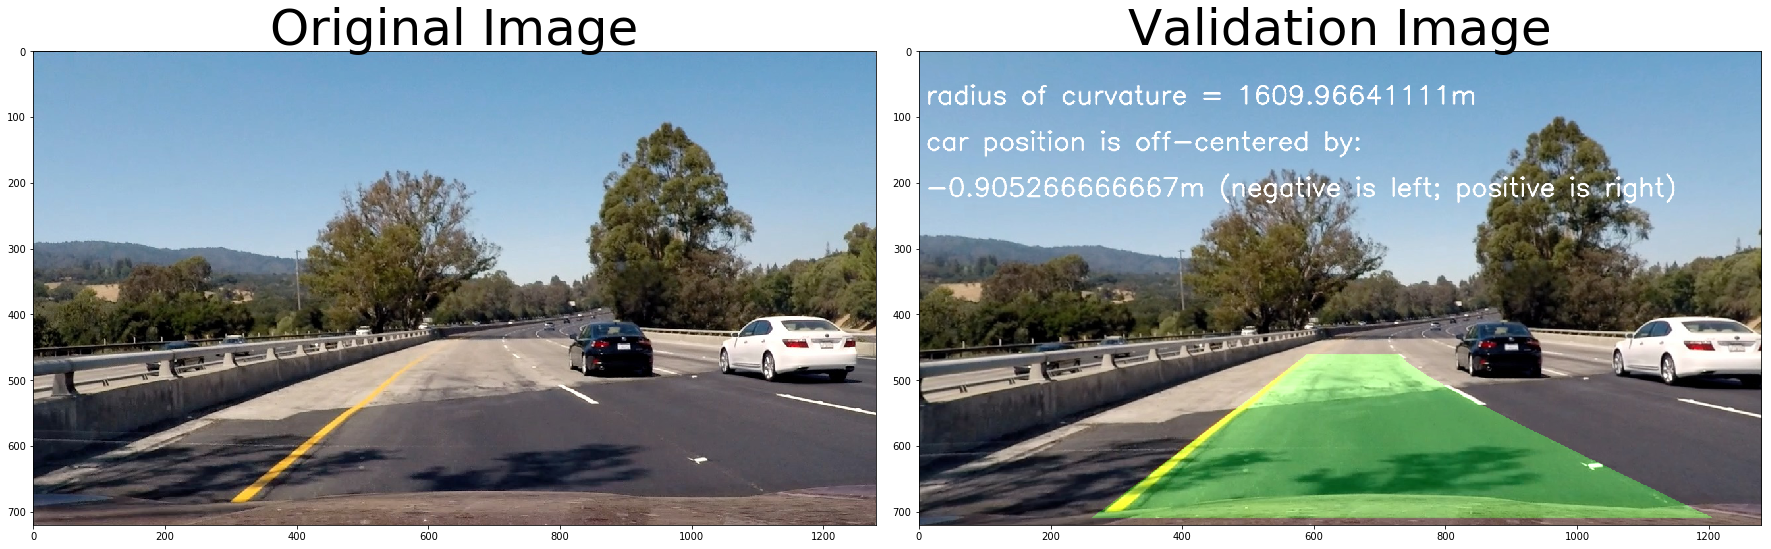

In [24]:

def MyGame(img0):
    image_1 = img0
    image_2 = cv2.undistort(image_1, mtx,dist,None,mtx) # un-distorted image
    image_3 = pipeline(image_2)  # binary image
    image_4 = warp(image_3) # warped image

    binary_warped = image_4
    # histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    histogram = np.sum(binary_warped[360:,:], axis=0)


    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    warped = image_4
    image = image_2

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_5 = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    out1, out2 = FindCurv(leftx,lefty,rightx,righty)
    
    line1 = 'radius of curvature = '+ out1
    line2 = 'car position is off-centered by:'
    line3 = out2
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image_5,line1,(10,80), font, 1.3,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image_5,line2,(10,150), font, 1.3,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image_5,line3,(10,220), font, 1.3,(255,255,255),2,cv2.LINE_AA)


    return image_5
image_A = mpimg.imread('test_images/test4.jpg') # original image
image = image_A
image_B = MyGame(image_A)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_A)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_B, cmap='gray')
ax2.set_title('Validation Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_vidoe = VideoFileClip("project_video.mp4")
output_video = 'project_video_lanes.mp4'
clip = input_vidoe.fl_image(MyGame) #NOTE: this function expects color images!!
clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████▉| 1260/1261 [03:59<00:00,  5.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 

